# Washington Bike Rentals

Many cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled that contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. 

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Exploring the data

In [2]:
# Importing data
bike_rentals = pd.read_csv("bike_rental_hour.csv")

bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


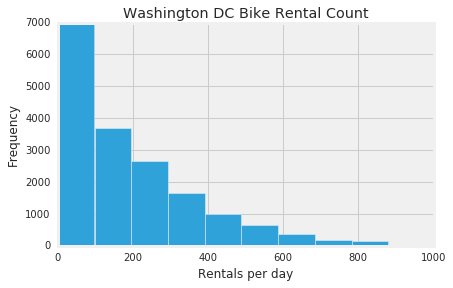

In [9]:
% matplotlib inline
# Looking at the frequency distribution of bike rentals per day
bike_rentals['cnt'].hist()
plt.title("Washington DC Bike Rental Count")
plt.xlabel("Rentals per day")
plt.ylabel("Frequency")
plt.show()


Correlation to bike rentals per day:
instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64


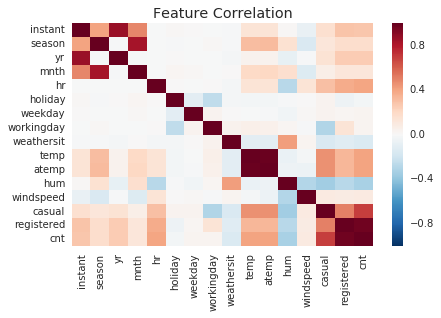

In [12]:
# Creating a correlation matrix 
bike_corr = bike_rentals.corr()
print("Correlation to bike rentals per day:\n{}".format(bike_corr['cnt']))

sns.heatmap(bike_corr)
plt.title("Feature Correlation")
plt.show()

## Feature Creation

Introducing some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

In [13]:
# A function to lump time periods together 
def assign_label(hour):
    if 6 < hour <= 12:
        label = 1
    elif 12 < hour <= 18:
        label = 2
    elif 18 < hour <= 24:
        label = 3
    else:
        label = 4
    return label

# Applying the assign_label function to the hr column of bike_rentals
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4


## Splitting the Data and Picking and Error Metric

Root Mean Square Error is a popular metric for regression problems.  It assumes that the error are unbiased and follow a normal distribution. 

Another potential error metric is R<sup>2</sup>, which  provides an indication of the goodness of fit of a set of predictions.  This is a value between 0 and 1 for no-fit and perfect fit respectively.

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Setting a sample number
cut_off = int(len(bike_rentals)*0.8)
# Creating a training datset using sample
train = bike_rentals.sample(cut_off, random_state=10)
# Selecting rows that are not in train to create test
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Selecting Features and Model Training

Leakage columns:
1) casual 
2) registered

Not useful for ML:
1) instant
2) dteday

The Linear Regression model will be used initially to make predictions on the cnt column

In [18]:
from sklearn.linear_model import LinearRegression
# Selecting columns to keep
columns_keep = bike_rentals.columns.drop(['casual', 'registered', 'instant', 'dteday', 'cnt'])

# Instantiating the model
lr = LinearRegression()
lr.fit(train[columns_keep], train['cnt'])
# Making predictions 
predictions = lr.predict(test[columns_keep])
# Calculating error
print("Root Mean Squared Error: {}".format(np.sqrt(mean_squared_error(test['cnt'], predictions))))
print("R Squared: {}".format(np.sqrt(r2_score(test['cnt'], predictions))))

Root Mean Squared Error: 128.10728082505875
R Squared: 0.7134164945763238


The count of bike rentals per day is off by about 128 riders, and the R<sup>2</sup> shows an okay fit, with a value of 0.71.  This can most likely be improved using a Decision Tree. 

In [19]:
from sklearn.tree import DecisionTreeRegressor
# Instantiating the model
dtr = DecisionTreeRegressor()
dtr.fit(train[columns_keep], train['cnt'])
# Making predictions 
predictions = dtr.predict(test[columns_keep])
# Calculating error
print("Default parameters")
print("Root Mean Squared Error: {}".format(np.sqrt(mean_squared_error(test['cnt'], predictions))))
print("R Squared: {}".format(np.sqrt(r2_score(test['cnt'], predictions))))

Root Mean Squared Error: 64.03349609367964
R Squared: 0.9366525369543627


In [32]:
# Instantiating the model
dtr = DecisionTreeRegressor(min_samples_split=30)
dtr.fit(train[columns_keep], train['cnt'])
# Making predictions 
predictions = dtr.predict(test[columns_keep])
# Calculating error
print("Changed: Minimum samples to split = 30")
print("Root Mean Squared Error: {}".format(np.sqrt(mean_squared_error(test['cnt'], predictions))))
print("R Squared: {}".format(np.sqrt(r2_score(test['cnt'], predictions))))

Changed: Minimum samples to split = 10
Root Mean Squared Error: 58.57717860162862
R Squared: 0.9472775541176954


In [29]:
# Instantiating the model
dtr = DecisionTreeRegressor(min_samples_leaf=5)
dtr.fit(train[columns_keep], train['cnt'])
# Making predictions 
predictions = dtr.predict(test[columns_keep])
# Calculating error
print("Changed: Minimum samples per leaf = 5")
print("Root Mean Squared Error: {}".format(np.sqrt(mean_squared_error(test['cnt'], predictions))))
print("R Squared: {}".format(np.sqrt(r2_score(test['cnt'], predictions))))

Changed: Minimum samples per leaf = 10
Root Mean Squared Error: 56.594106000027026
R Squared: 0.9508776793351488


Using a Decision Tree Regressor improved the R<sup>2</sup> value substantially and reduced the RMSE.  Setting the min_sample_leaf to 5 also improved the prediction accuracy slightly.  

In [36]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(train[columns_keep], train['cnt'])
# Making predictions 
predictions = rfr.predict(test[columns_keep])
# Calculating error
print("Default parameters")
print("Root Mean Squared Error: {}".format(np.sqrt(mean_squared_error(test['cnt'], predictions))))
print("R Squared: {}".format(np.sqrt(r2_score(test['cnt'], predictions))))

Default parameters
Root Mean Squared Error: 47.266941356145104
R Squared: 0.9659984801556915


In [37]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(min_samples_leaf=5)
rfr.fit(train[columns_keep], train['cnt'])
# Making predictions 
predictions = rfr.predict(test[columns_keep])
# Calculating error
print("Changed: Minimum samples per leaf = 5")
print("Root Mean Squared Error: {}".format(np.sqrt(mean_squared_error(test['cnt'], predictions))))
print("R Squared: {}".format(np.sqrt(r2_score(test['cnt'], predictions))))

Changed: Minimum samples per leaf = 5
Root Mean Squared Error: 50.740408026510195
R Squared: 0.9607119362637409


The prediciton fit improves further with the use of RandomForestRegressor, changing the min_sample_leaf to reflect the same value chosen for the DecisionTreeRegressor slightly reduced the accuracy of the model.

## Prediction Registered Riders

In [43]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(train[columns_keep], train['registered'])
# Making predictions 
predictions = rfr.predict(test[columns_keep])
# Calculating error
print("Registered Riders")
print("Root Mean Squared Error: {}".format(np.sqrt(mean_squared_error(test['registered'], predictions))))
print("R Squared: {}".format(np.sqrt(r2_score(test['registered'], predictions))))

Registered Riders
Root Mean Squared Error: 40.10828221451534
R Squared: 0.9654435077461617


## Prediction of Casual Riders

In [44]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(train[columns_keep], train['casual'])
# Making predictions 
predictions = rfr.predict(test[columns_keep])
# Calculating error
print("Casual Riders")
print("Root Mean Squared Error: {}".format(np.sqrt(mean_squared_error(test['casual'], predictions))))
print("R Squared: {}".format(np.sqrt(r2_score(test['casual'], predictions))))

Casual Riders
Root Mean Squared Error: 16.460825769138008
R Squared: 0.9410202128424798


Overall, teh RandomForestRegressor was able to make accurate predictions for the number of casual riders, registered riders and the total daily riders.  The reduced RMSE is most likely due to the smaller numbers associated with casual riders and registered riders, vs the total riders and not necessarily increased model accuracy.  